## Dynamic Programming - Iterative Policy Evaluation

Dynamic programming is a method of computing an optimal policy given a *perfect* model of an environment.

This is an implementation of Example 4.1 in [Policy Evaluation](http://incompleteideas.net/book/ebook/node41.html). The goal is to get to the corners in the fewest steps.

![gridworld](http://incompleteideas.net/book/ebook/imgtmp4.png)

I made a value function that uses iterative policy evaluation to update state values.
The policy used is a greedy policy based on the value function at that moment in time.


In this basic gridworld example, the greedy policy is the optimal policy, so we end up finding the optimal value function $V^*$ through this approach.

In [1]:
from gridworld.world import World, Coordinate, actions, Direction

In [2]:
x_len = 6
y_len = 6
def reward_function(coordinate: Coordinate):
    return -1

def initialize_world(initial_position=Coordinate(2, 3)):
    world = World(x_len, y_len, reward_function, initial_position=initial_position)
    world.print()
    return world

world = initialize_world()

......
......
......
..X...
......
......


Here is the iterative policy evaluation loop.

I use a form of the Bellman equation for the greedy policy $\pi$. 

$$ V_{k+1} = \sum_a \pi(s, a) \sum_{s'} P^a_{ss'} [ R^a_{ss'} + \gamma V_k (s')] $$

- $\pi(s, a)$ is the probabillity of taking an action $a$ from that state $s$. The greedy policy will return a list of actions that are greedy given the value function $V_k$. Since the probability of selecting either of these actions is equal, this manifests in the algorithm by dividing the sum by the count of the possible actions.
- $P^a_{ss'}$ is the probability that taking action $a$ will result in state $s$ transitioning to state $s'$. Our gridworld is deterministic, so this is 1 and is ignored in the algorithm.
- $R_{ss'}^a$ is the reward of the state transition from state $s$ to state $s'$. In this environment, it's always -1.
- $V_k(s')$ is the old value function's determination of the next state value. It's multiplied by $\gamma$ (some number less than 1 and greater than 0) to assure convergence.

I iterate until $\Delta$ is smaller than some small number; it ends up taking only 6 iterations to converge entirely.

In [3]:
import numpy as np
from typing import List

state_value_map = [[0 for x in range(x_len)] for y in range(y_len)]
def value_function(state: Coordinate) -> float:
    return state_value_map[state.x][state.y]

def policy_function(state: Coordinate) -> List[Direction]:
    # The greedy policy.
    # Returns a list of actions that maximize the value function. 
    # If there are multiple actions that maximize the value function, return them all.
    max_value = -float('inf')
    max_actions = []
    for action in actions:
        next_coordinate = world.move_direction(state, action)
        value = value_function(next_coordinate)
        if value > max_value:
            max_value = value
            max_actions = [action]
        elif value == max_value:
            max_actions.append(action)
    return max_actions

gamma = 0.9
def update_value_function():
    iterations = 0
    while True:
        iterations += 1
        value_function_delta = 0
        for x in range(x_len):
            for y in range(y_len):
                state = Coordinate(x, y)
                # Assuming a Greedy policy with respect to the current value function (`policy_function`)
                # Incrementally updating the state value map for faster convergence
                old_state = state_value_map[x][y]
                # Get possible actions for the current state
                # If the current state is in the goal state, then the value function is 0
                if state == Coordinate(x_len - 1, y_len - 1):
                    state_value_map[x][y] = 0
                elif state == Coordinate(0, 0):
                    state_value_map[x][y] = 0
                else:
                    possible_actions = policy_function(state)
                    action_count = len(possible_actions)
                    state_value_map[x][y] = float(np.array([-1 + (gamma * value_function(world.move_direction(state, action))) for action in possible_actions]).sum()) / action_count
                value_function_delta = max(value_function_delta, abs(old_state - state_value_map[x][y]))

        if value_function_delta < 0.00001:
            break

    return iterations


In [4]:
def print_state_value_map():
    for row in state_value_map:
        for cell in row:
            print(f"{cell:.1f}", end=", ")
        print()


print("Initial value function:")
print_state_value_map()

iterations = update_value_function()

print(f"After {iterations} iteration of updating the value function:")
print_state_value_map()

Initial value function:
0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
After 6 iteration of updating the value function:
0.0, -1.0, -1.9, -2.7, -3.4, -4.1, 
-1.0, -1.9, -2.7, -3.4, -4.1, -3.4, 
-1.9, -2.7, -3.4, -4.1, -3.4, -2.7, 
-2.7, -3.4, -4.1, -3.4, -2.7, -1.9, 
-3.4, -4.1, -3.4, -2.7, -1.9, -1.0, 
-4.1, -3.4, -2.7, -1.9, -1.0, 0.0, 


In [17]:
world = initialize_world()

def step_with_policy_function():
    directions = policy_function(world.current_position)
    direction = np.random.choice(directions)
    world.move(direction)

steps = 0
while not (world.current_position == Coordinate(x_len - 1, y_len - 1) or world.current_position == Coordinate(0, 0)):
    steps += 1
    step_with_policy_function()

print("-" * 8)
world.print()
print(f"Made it in {steps} steps!")

......
......
......
..X...
......
......
--------
X.....
......
......
......
......
......
Made it in 5 steps!


# Policy Iteration

This is a demo of the example in the chapter on policy iteration.

A simulation of Jack's multi-location car rental company.
http://incompleteideas.net/sutton/book/ebook/node43.html (example 4.2)

- The number of cars requested and returned at each location is a Poisson random variable.
- Suppose lambda is 3 and 4 for rental requests and 3 and 2 for returns. 
  - The probabilities should be different for both dealerships.
- If a car is available, Jack is credited $10.
- Jack can move cars between dealerships at $2/car.
  - A maximum of five cars can be moved from one location to the other in one night
- There can be no more than 20 cars at a location (any additional cars returned are ignored)

What happens if we do nothing?

In [21]:
from carrentals.carrentals import Rental, RentalProbability, RentalState

max_cars = 20

def initialize_rental():
    rental = Rental(
        max_cars=max_cars,
        rental_probability1=RentalProbability(
            rental_probability=3,
            return_probability=3,
        ),
        rental_probability2=RentalProbability(
            rental_probability=4,
            return_probability=2,
        ),
        initial_state=RentalState(
            cars_at_location1=0,
            cars_at_location2=0,
        )
    )

    return rental

rental = initialize_rental()

In [22]:

running_sum = 0
runs = 10000
for run in range(runs):
    rental = initialize_rental()

    total_rewards = 0

    for i in range(31):
        total_rewards += rental.step(0)[0]

    running_sum += total_rewards

print(f"Average rewards: {running_sum / runs}")


Average rewards: 719.82


If we do nothing, we get ~$700/mo (starting from 0 cars in both rental location each month). Not bad. But we have the option to transfer cars to optimize our reward.

Our state and action space is finite. We can have between 0 and 20 cars at each rental location and can transfer up to 5 cars between either rental location.
Since state and action are finite, we can treat this as a finite MDP.

Instead of using the greedy policy, we'll use policy iteration to choose the best action in the given state.

---

During the policy iteration and evaluation phase, we track the possible state transitions and the probability that they will happen; we're tracking the transitions that represent the most likely state transitions (>98.5%), which ends up being about 6000 possible state transitions with different rewards from each state. 

In [4]:
sum(map(lambda x: x[1], rental.possible_state_transitions(RentalState(20, 20))))

0.9851036608121629

In [5]:
sum(map(lambda x: x[1], rental.possible_state_transitions(RentalState(0,0))))

0.9851036608121629

In [6]:
sum(map(lambda x: x[1], rental.possible_state_transitions(RentalState(9,15))))


0.9851036608121629

Next, I initialize the value function and policy function. They are both initialized to all zeros in the state space.

If I were to do this more efficiently, I'd use a numpy array, but for simplicity I used an iterator and dictionaries to encode `state->action` and `state->value`. 

The last thing I initialize is a state transition map, which is useful to store during policy iteration and evaluation (these values will need to be used for every iteration, and since it's 6000 transitions for each state it's useful to precompute and store here).

In [8]:

from typing import Tuple

def iterate_through_state_space():
    for car_count1 in range(max_cars + 1):
        for car_count2 in range(max_cars + 1):
            yield RentalState(
                cars_at_location1=car_count1,
                cars_at_location2=car_count2,
            )

def state_hash(state: RentalState) -> Tuple[int, int]:
    return state.cars_at_location1, state.cars_at_location2
            

# The policy is encoded as a dictionary of state -> action
state_action_map = {
    state_hash(state): 0
    for state in iterate_through_state_space()
}
def policy_function(state: RentalState) -> int:
    return state_action_map[state_hash(state)]

state_value_map = {
    state_hash(state): 0
    for state in iterate_through_state_space()
}
def value_function(state: RentalState) -> float:
    return state_value_map[state_hash(state)]

state_transitions = {
    state_hash(state): rental.possible_state_transitions(state)
    for state in iterate_through_state_space()
}

This defines the policy evaluation loop. It updates the value function according to the Bellman equation.

In [11]:

gamma = 0.9
def policy_evaluation():
    # Updates the value function for the current policy until the delta is small enough.
    count = 0
    while True:
        delta = 0
        count += 1
        for state in iterate_through_state_space():
            old_value = value_function(state)
            action = policy_function(state)
            # The state transitions are not 100% deterministic. The probability of the next state is dependent on a poisson distribution.
            action_penalty, resulting_state = rental.take_action(state, action)
            state_value_map[state_hash(state)] = sum([
                p * ((reward + action_penalty) + gamma * value_function(possible_next_state))
                for possible_next_state, p, reward in state_transitions[state_hash(resulting_state)]
            ])
            delta = max(delta, abs(old_value - value_function(state)))
        if count % 1 == 0:
            print(f"Iteration {count}: delta = {delta}")
        if delta < 0.0001:
            break


Let's see what we get when we converge to $V^\pi$ where $\pi$ is just all 0s...

In [12]:
policy_evaluation()

Iteration 1: delta = 185.6989724898836
Iteration 2: delta = 125.11033380582896
Iteration 3: delta = 80.30089351821013
Iteration 4: delta = 53.87255075915823
Iteration 5: delta = 35.84459418458954
Iteration 6: delta = 23.968627768976205
Iteration 7: delta = 16.419108990712118
Iteration 8: delta = 12.402259882437932
Iteration 9: delta = 10.005253798726102
Iteration 10: delta = 8.118562578852902
Iteration 11: delta = 6.91531768545596
Iteration 12: delta = 5.859830890378149
Iteration 13: delta = 4.944718967725834
Iteration 14: delta = 4.158139832120767
Iteration 15: delta = 3.486530419203433
Iteration 16: delta = 2.916125346436388
Iteration 17: delta = 2.43377774817813
Iteration 18: delta = 2.0273749274272745
Iteration 19: delta = 1.6860166860287507
Iteration 20: delta = 1.4000549519510912
Iteration 21: delta = 1.1610539652795637
Iteration 22: delta = 0.9617072499295887
Iteration 23: delta = 0.7957337015100734
Iteration 24: delta = 0.6577665100008971
Iteration 25: delta = 0.543243189802694

/tmp/ipykernel_146872/1130052313.py:41: UserWarning: No contour levels were found within the data range.
  ax.contour3D(x, y, z, 50, cmap="viridis")


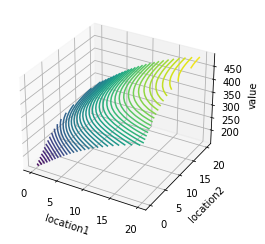

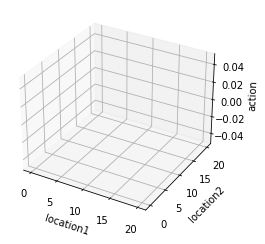

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def render_value_function():
    x = []
    y = []
    z = []
    for state in iterate_through_state_space():
        if not state.cars_at_location1 in x:
            x.append(state.cars_at_location1)
        if not state.cars_at_location2 in y:
            y.append(state.cars_at_location2)
        z.append(value_function(state))

    z = np.array(z)
    z = z.reshape((len(x), len(y)))
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    x, y = np.meshgrid(x, y)
    ax.contour3D(x, y, z, 50, cmap="viridis")
    ax.set_xlabel("location1")
    ax.set_ylabel("location2")
    ax.set_zlabel("value")

def render_policy_function():
    x = []
    y = []
    z = []
    for state in iterate_through_state_space():
        if not state.cars_at_location1 in x:
            x.append(state.cars_at_location1)
        if not state.cars_at_location2 in y:
            y.append(state.cars_at_location2)
        z.append(policy_function(state))

    z = np.array(z)
    z = z.reshape((len(x), len(y)))
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    x, y = np.meshgrid(x, y)
    ax.contour3D(x, y, z, 50, cmap="viridis")
    ax.set_xlabel("location1")
    ax.set_ylabel("location2")
    ax.set_zlabel("action")

render_value_function()
render_policy_function()

The value function is similar to the one shown in Barto & Sutton; the contour of the value map increases with a maximum on 20, 20. This conceptually makes sense; the most valuable position to be in is the one with the most cars to rent.

The render of the policy function is blank because the policy is all 0s. 

Let's declare the policy improvement phase. In this phase, we find the $\underset{a}{argmax} \sum_{s'} P^a_{ss'} [ R^a_{ss'} + \gamma V(s') ]$; finding the action that maximizes the possible value from state $s$, taking in all possible transitions to state $s'$ and those rewards and probabilities into account, and updating the policy function to take that action. 

In [14]:
def policy_improvement():
    stable = True
    for state in iterate_through_state_space():
        # get current policy's action
        cur_action = policy_function(state)

        ex = state.cars_at_location2 >= 15 and state.cars_at_location2 <= 18 and state.cars_at_location1 > 3
        # Get the action that gets the greatest reward
        # update the policy such that that action will be taken
        max_action = None
        max_action_value = float('-inf')
        for action in range(-5, 6):
            action_penalty, resulting_state = rental.take_action(state, action)
            action_value = sum([
                p * (reward + gamma * value_function(possible_next_state))
                for possible_next_state, p, reward in state_transitions[state_hash(resulting_state)]
            ]) + action_penalty
            
            if action_value > max_action_value:
                max_action = action
                max_action_value = action_value

        if max_action != cur_action:
            state_action_map[state_hash(state)] = max_action
            stable = False


    return stable

The full policy improvement process is to repeatedly evaluate the policy and improve it until it's stable. When the policy is stable, we've found the optimal policy!

In [15]:
stable = False
while not stable:
    policy_evaluation()
    stable = policy_improvement()

Iteration 1: delta = 7.12534535409759e-05
Iteration 1: delta = 108.23079224460093
Iteration 2: delta = 9.418238433321335
Iteration 3: delta = 4.10935300139181
Iteration 4: delta = 2.5162582580605317
Iteration 5: delta = 1.8572664793781541
Iteration 6: delta = 1.303488099873789
Iteration 7: delta = 0.928466240058242
Iteration 8: delta = 0.7205941943117011
Iteration 9: delta = 0.6033270410010232
Iteration 10: delta = 0.5002815840039148
Iteration 11: delta = 0.4126278686907767
Iteration 12: delta = 0.33930806136282854
Iteration 13: delta = 0.27853384415649884
Iteration 14: delta = 0.22841444920453569
Iteration 15: delta = 0.18720208349714085
Iteration 16: delta = 0.15337114661753048
Iteration 17: delta = 0.12562725726425583
Iteration 18: delta = 0.10288871785672882
Iteration 19: delta = 0.08425916390351063
Iteration 20: delta = 0.06899939252659237
Iteration 21: delta = 0.056501526829890736
Iteration 22: delta = 0.046266521692189144
Iteration 23: delta = 0.03788509093666903
Iteration 24: d

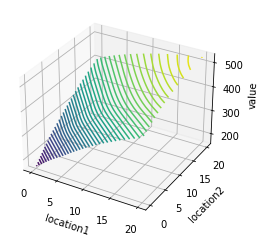

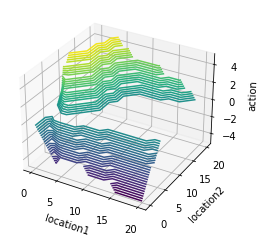

In [16]:
render_value_function()
render_policy_function()

Nice, this very closely resembles Barto and Sutton's policy function representation. 

Let's see how it performs on average:

In [23]:
running_sum = 0
runs = 10000
for run in range(runs):
    rental = initialize_rental()

    total_rewards = 0

    for i in range(31):
        action = policy_function(rental.state)
        #print(rental.state, action)
        rewards = rental.step(action)[0]
        #print(f"rewards: {rewards}")
        total_rewards += rewards

    running_sum += total_rewards

print(f"Average rewards: {running_sum / runs}")



Average rewards: 767.5044


Nice! It's about a $50/mo improvement over doing nothing!